In [6]:
import numpy as np
import torch
import lightning.pytorch as pl
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex=True)

import pandas as pd
import matplotlib.pyplot as plt

import urllib

In [51]:

# Generate a random length between 10 and 30
length = np.random.randint(10, 31)

# Create a random array of 0s and 1s with the random length
data_array = np.random.randint(2, size=length)

# Initialize an array to store the cumulative sum of random_array
cumulative_sum = np.cumsum(data_array)

# Calculate parity for each cumulative sum and save to a separate array
parity_array = cumulative_sum % 2

# No We need to convert Array to Encoding 0s = 3 and 1s = 4
enc_data_array = np.where(data_array == 0, 3, 4)
enc_parity_array = np.where(parity_array == 0, 3, 4)

enc_data_array = np.concatenate(([1], enc_data_array, [2]))
enc_parity_array = np.concatenate(([1], enc_parity_array, [2]))

enc_data_array = np.pad(enc_data_array, (0, 30 - length), 'constant')
enc_parity_array = np.pad(enc_parity_array, (0, 30 - length), 'constant')



print("\nArray of 0s and 1s:")
print("Data Array:         ", data_array)
print("Parity Array:       ", parity_array)
print("\nEncoded:\nKey: 1 = Start, 2 = Stop, 3 = Zero, 4 = One, 0 = Padding / Empty")
print("Data Array (enc):   ", enc_data_array)
print("Parity Array (enc): ", enc_parity_array)



Array of 0s and 1s:
Data Array:          [1 1 0 1 0 1 1 0 0 1 0 1 1 0 1 0]
Parity Array:        [1 0 0 1 1 0 1 1 1 0 0 1 0 0 1 1]

Encoded:
Key: 1 = Start, 2 = Stop, 3 = Zero, 4 = One, 0 = Padding / Empty
Data Array (enc):    [1 4 4 3 4 3 4 4 3 3 4 3 4 4 3 4 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Parity Array (enc):  [1 4 3 3 4 4 3 4 4 4 3 3 4 3 3 4 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [30]:
# Set the seed for reproducibility (optional)
np.random.seed(0)

# Generate 100 random arrays with lengths between 10 and 30
num_arrays = 100
min_length = 10
max_length = 30
arrays_list = []

for _ in range(num_arrays):
    length = np.random.randint(min_length, max_length + 1)
    random_array = np.random.randint(2, size=length)
    # Right pad with 0s to make the length consistent
    padded_array = np.pad(random_array, (0, max_length - length), 'constant')
    arrays_list.append(padded_array)

# Convert the list of arrays into a 2D NumPy array
final_array = np.array(arrays_list)

# Print the shape of the final array
print(final_array.shape)

final_array[0]


(100, 30)


array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0])

In [2]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    print(torch.cuda.get_device_properties("cuda"))
    print("Number of devices:",torch.cuda.device_count())
    device = ("cuda")
else:
    print("Only CPU is available...")
    device = ("cpu")

NVIDIA GeForce RTX 2080 Ti
_CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11011MB, multi_processor_count=68)
Number of devices: 1


In [3]:
# Setup URL to Data File
url = "https://raw.githubusercontent.com/luisroque/deep-learning-articles/main/data/eng-por.txt"

data = []
with urllib.request.urlopen(url) as raw_data:
    for line in raw_data:
        data.append(line.decode("utf-8").split('\t')[0:2])
data = np.array(data)

data.shape

In [4]:
# Subset? - All of the data will take some time...
n_seq = data.shape[0]
n_seq = 100
data = data[0:n_seq]
split_point = int(data.shape[0] * 0.8) # Keep 80/20 split
np.random.shuffle(data) # In-place modification
max_length = np.max([len(i) for i in data.flatten()]) + 2 # Add start/stop

print(f"max_length = ${max_length}")
print(f"data[0] => ${data[0]}")

max_length = $23
data[0] => $['Jump.' 'Pulem.']


In [5]:
# Setup
i_to_c_eng = ['','<START>','<STOP>'] + list({char for word in data[:,0] for char in word})
c_to_i_eng = {i_to_c_eng[i]:i for i in range(len(i_to_c_eng))}
i_to_c_eng[1] = i_to_c_eng[2] = ''

i_to_c_por = ['','<START>','<STOP>'] + list({char for word in data[:,1] for char in word})
c_to_i_por = {i_to_c_por[i]:i for i in range(len(i_to_c_por))}
i_to_c_por[1] = i_to_c_por[2] = ''


In [6]:
def encode_seq(x, mapping, max_length=0):
    # String to integer
    return [mapping['<START>']] + \
    [mapping[i] for i in list(x)] + \
    [mapping['<STOP>']] + \
    [0]*(max_length-len(list(x))-2)
    
def decode_seq(x, mapping):
    # Integer-to-string
    try:
        idx = list(x).index(2) # Stop token?
    except:
        idx = len(list(x)) # No stop token found
    return ''.join([mapping[i] for i in list(x)[0:idx]])

In [7]:
data[0]


array(['Jump.', 'Pulem.'], dtype='<U184')

In [8]:
data[0,0]

'Jump.'

In [9]:
temp = encode_seq(data[0,0],c_to_i_eng,max_length)

print(temp)

[1, 22, 37, 16, 33, 12, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [10]:
decode_seq(temp, i_to_c_eng)

'Jump.'

In [11]:
data[0,1]

'Pulem.'

In [12]:
temp = encode_seq(data[0,1],c_to_i_por,max_length)

print(temp)

[1, 34, 48, 31, 9, 21, 14, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [13]:
decode_seq(temp, i_to_c_por)

'Pulem.'

In [14]:
# Setup
X = np.vstack([encode_seq(x, c_to_i_eng, max_length) for x in data[:,0]])
Y = np.vstack([encode_seq(x, c_to_i_por, max_length) for x in data[:,1]])

enc_x_train = X[:split_point]
enc_x_val = X[split_point:]
enc_x_train


array([[ 1, 22, 37, ...,  0,  0,  0],
       [ 1, 34, 37, ...,  0,  0,  0],
       [ 1, 43, 15, ...,  0,  0,  0],
       ...,
       [ 1,  6,  7, ...,  0,  0,  0],
       [ 1, 20, 11, ...,  0,  0,  0],
       [ 1,  4, 15, ...,  0,  0,  0]])

In [15]:
# Setup
dec_x_train = Y[:,0:-1][:split_point]
dec_x_val = Y[:,0:-1][split_point:]
dec_x_train

array([[ 1, 34, 48, ...,  0,  0,  0],
       [ 1, 23, 37, ...,  0,  0,  0],
       [ 1, 34, 42, ...,  0,  0,  0],
       ...,
       [ 1, 25,  9, ...,  0,  0,  0],
       [ 1,  4, 48, ...,  0,  0,  0],
       [ 1,  5, 20, ...,  0,  0,  0]])

In [16]:
dec_y_train = Y[:,1:][:split_point]
dec_y_val = Y[:,1:][split_point:]
dec_y_train

array([[34, 48, 31, ...,  0,  0,  0],
       [23, 37, 47, ...,  0,  0,  0],
       [34, 42, 47, ...,  0,  0,  0],
       ...,
       [25,  9, 35, ...,  0,  0,  0],
       [ 4, 48,  9, ...,  0,  0,  0],
       [ 5, 20, 42, ...,  0,  0,  0]])

In [17]:
print(enc_x_train.shape)
print(dec_x_train.shape)
print(dec_y_train.shape)

print("----")

print(enc_x_val.shape)
print(dec_x_val.shape)
print(dec_y_val.shape)

(80, 23)
(80, 22)
(80, 22)
----
(20, 23)
(20, 22)
(20, 22)


In [18]:
len(i_to_c_eng)

In [19]:
len(i_to_c_por)

In [20]:
enc_x_train.shape[1:]

In [21]:
class RecurrentResidual(torch.nn.Module):
    def __init__(self,
                 latent_size = 64,
                 bidirectional = False,
                 **kwargs):
        super().__init__(**kwargs)
        self.layer_norm = torch.nn.LayerNorm(latent_size)
        self.rnn_layer = torch.nn.RNN(latent_size,
                                      latent_size // 2 if bidirectional else latent_size,
                                      bidirectional=bidirectional,
                                      nonlinearity='tanh',
                                      batch_first=True)
    def forward(self, x):
        return x + self.rnn_layer(self.layer_norm(x))[0]

class EncoderNetwork(torch.nn.Module):
    def __init__(self,
                 num_tokens,
                 latent_size = 64, # Use something divisible by 2
                 n_layers = 4,
                 **kwargs):
        super().__init__(**kwargs)
        self.embedding = torch.nn.Embedding(num_tokens,
                                            latent_size,
                                            padding_idx=0)
        self.dropout = torch.nn.Dropout1d(0.1) # Whole token dropped
        self.rnn_layers = torch.nn.Sequential(*[
            RecurrentResidual(latent_size, True) for _ in range(n_layers)
        ])
        
    def forward(self, x):
        y = x
        y = self.embedding(y)
        y = self.dropout(y)
        y = self.rnn_layers(y)[:,-1]
        return y


In [22]:
enc_x_train[0:5].shape

In [23]:
enc_net = EncoderNetwork(num_tokens=len(i_to_c_eng))
summary(enc_net,input_data=torch.Tensor(enc_x_train[0:5]).long())

Layer (type:depth-idx)                   Output Shape              Param #
EncoderNetwork                           [5, 64]                   --
├─Embedding: 1-1                         [5, 23, 64]               2,816
├─Dropout1d: 1-2                         [5, 23, 64]               --
├─Sequential: 1-3                        [5, 23, 64]               --
│    └─RecurrentResidual: 2-1            [5, 23, 64]               --
│    │    └─LayerNorm: 3-1               [5, 23, 64]               128
│    │    └─RNN: 3-2                     [5, 23, 64]               6,272
│    └─RecurrentResidual: 2-2            [5, 23, 64]               --
│    │    └─LayerNorm: 3-3               [5, 23, 64]               128
│    │    └─RNN: 3-4                     [5, 23, 64]               6,272
│    └─RecurrentResidual: 2-3            [5, 23, 64]               --
│    │    └─LayerNorm: 3-5               [5, 23, 64]               128
│    │    └─RNN: 3-6                     [5, 23, 64]               6,272


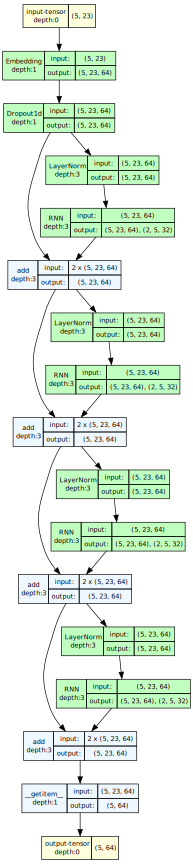

In [24]:
model_graph = draw_graph(enc_net,
                         input_data = torch.Tensor(enc_x_train[0:5]).long(),
                         device=device,
                         hide_inner_tensors=True,
                         hide_module_functions=True,
                         expand_nested=False,
                         depth=3,
                         dtypes=[torch.long])
model_graph.visual_graph

In [25]:
# Decoder Component
class DecoderNetwork(torch.nn.Module):
    def __init__(self,
                 num_tokens,
                 latent_size = 64, # Use something divisible by 2
                 n_layers = 4,
                 **kwargs):
        super().__init__(**kwargs)
        self.embedding = torch.nn.Embedding(num_tokens,
                                            latent_size,
                                            padding_idx=0)
        self.dropout = torch.nn.Dropout1d(0.1) # Whole token dropped
        self.linear = torch.nn.Linear(latent_size*2, latent_size)
        self.rnn_layers = torch.nn.Sequential(*[
            RecurrentResidual(latent_size,False) for _ in range(n_layers)
        ])
        self.output_layer = torch.nn.Linear(latent_size,
                                            num_tokens)
    
    def forward(self, x_enc, x_dec):
        y_enc = x_enc.unsqueeze(1).repeat(1,x_dec.shape[1],1)
        y_dec = self.embedding(x_dec)
        y_dec = self.dropout(y_dec)
        y = y_enc
        y = torch.concatenate([y_enc,y_dec],-1)
        y = self.linear(y)
        y = self.rnn_layers(y)
        y = self.output_layer(y)
        return y


In [26]:
enc_x_train[0:5].shape

In [27]:
dec_x_train[0:5].shape

In [28]:
# Passed through the encoder network - output tensor shape for decoder
enc_net(torch.Tensor(enc_x_train[0:5]).long().to(device)).shape

torch.Size([5, 64])

In [29]:
dec_net = DecoderNetwork(num_tokens=len(i_to_c_por))
summary(dec_net,input_data=[enc_net(torch.Tensor(enc_x_train[0:5]).long().to(device)).cpu(), torch.Tensor(dec_x_train[0:5]).long()])

Layer (type:depth-idx)                   Output Shape              Param #
DecoderNetwork                           [5, 22, 56]               --
├─Embedding: 1-1                         [5, 22, 64]               3,584
├─Dropout1d: 1-2                         [5, 22, 64]               --
├─Linear: 1-3                            [5, 22, 64]               8,256
├─Sequential: 1-4                        [5, 22, 64]               --
│    └─RecurrentResidual: 2-1            [5, 22, 64]               --
│    │    └─LayerNorm: 3-1               [5, 22, 64]               128
│    │    └─RNN: 3-2                     [5, 22, 64]               8,320
│    └─RecurrentResidual: 2-2            [5, 22, 64]               --
│    │    └─LayerNorm: 3-3               [5, 22, 64]               128
│    │    └─RNN: 3-4                     [5, 22, 64]               8,320
│    └─RecurrentResidual: 2-3            [5, 22, 64]               --
│    │    └─LayerNorm: 3-5               [5, 22, 64]               128


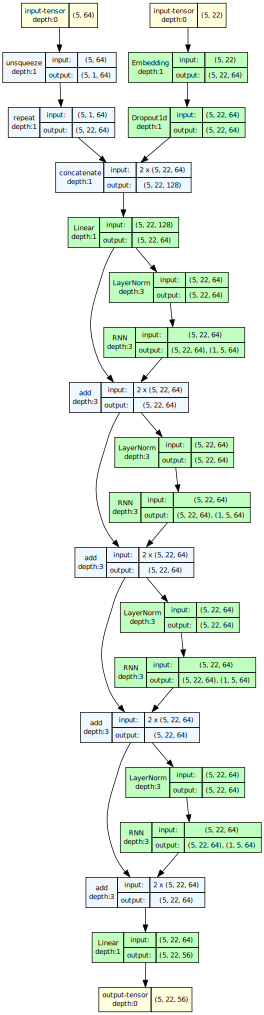

In [32]:
model_graph = draw_graph(dec_net,
                         input_data=[enc_net(torch.Tensor(enc_x_train[0:5]).long().to(device)), torch.Tensor(dec_x_train[0:5]).long()],
                         device=device,
                         hide_inner_tensors=True,
                         hide_module_functions=True,
                         expand_nested=False,
                         depth=3,
                         dtypes=[torch.long])

model_graph.visual_graph

In [35]:
class EncDecLightningModule(pl.LightningModule):
    def __init__(self,
                 output_size,
                 **kwargs):
        super().__init__(**kwargs)
        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass',
                                                           num_classes=output_size,
                                                           ignore_index=0)
        self.cce_loss = torch.nn.CrossEntropyLoss(ignore_index=0)

    def predict(self, x):
        return torch.softmax(self(x),-1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x_enc, x_dec, y_dec = train_batch
        y_pred = self(x_enc, x_dec)
        perm = (0,-1) + tuple(range(y_pred.ndim))[1:-1]
        acc = self.mc_acc(y_pred.permute(*perm),y_dec)
        loss = self.cce_loss(y_pred.permute(*perm),y_dec)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    # Validate used for Teacher Forcing
    def validation_step(self, val_batch, batch_idx):
        x_enc, x_dec, y_dec = val_batch
        y_pred = self(x_enc, x_dec)
        perm = (0,-1) + tuple(range(y_pred.ndim))[1:-1]
        acc = self.mc_acc(y_pred.permute(*perm),y_dec)
        loss = self.cce_loss(y_pred.permute(*perm),y_dec)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    # Test used for Non-Teacher Forcing
    def test_step(self, test_batch, batch_idx):
        x_enc, x_dec, y_dec = test_batch
        context = self.enc_net(x_enc)
        tokens = torch.zeros_like(x_dec).long()
        tokens[:,0] = 1
        for i in range(y_dec.shape[1]-1):
            tokens[:,i+1] = self.dec_net(context, tokens).argmax(-1)[:,i]
        y_pred = self(x_enc, tokens)
        perm = (0,-1) + tuple(range(y_pred.ndim))[1:-1]
        acc = self.mc_acc(y_pred.permute(*perm),y_dec)
        loss = self.cce_loss(y_pred.permute(*perm),y_dec)
        self.log('test_acc', acc, on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss


In [37]:
class EncDecNetwork(EncDecLightningModule):
    def __init__(self,
                 num_enc_tokens,
                 num_dec_tokens,
                 latent_size = 64, # Use something divisible by 2 
                 n_layers = 4,
                 **kwargs):
        super().__init__(output_size=num_dec_tokens, **kwargs)
        self.enc_net = EncoderNetwork(num_enc_tokens,latent_size,n_layers)
        self.dec_net = DecoderNetwork(num_dec_tokens,latent_size,n_layers)
    
    def forward(self, x_enc, x_dec):
        return self.dec_net(self.enc_net(x_enc), x_dec)

In [38]:
enc_dec_net = EncDecNetwork(num_enc_tokens=len(i_to_c_eng),
                            num_dec_tokens=len(i_to_c_por))

summary(enc_dec_net,input_data=[torch.Tensor(enc_x_train[0:1]).long(),
                                torch.Tensor(dec_x_train[0:1]).long()])

Layer (type:depth-idx)                   Output Shape              Param #
EncDecNetwork                            [1, 22, 56]               --
├─EncoderNetwork: 1-1                    [1, 64]                   --
│    └─Embedding: 2-1                    [1, 23, 64]               2,816
│    └─Dropout1d: 2-2                    [1, 23, 64]               --
│    └─Sequential: 2-3                   [1, 23, 64]               --
│    │    └─RecurrentResidual: 3-1       [1, 23, 64]               6,400
│    │    └─RecurrentResidual: 3-2       [1, 23, 64]               6,400
│    │    └─RecurrentResidual: 3-3       [1, 23, 64]               6,400
│    │    └─RecurrentResidual: 3-4       [1, 23, 64]               6,400
├─DecoderNetwork: 1-2                    [1, 22, 56]               --
│    └─Embedding: 2-4                    [1, 22, 64]               3,584
│    └─Dropout1d: 2-5                    [1, 22, 64]               --
│    └─Linear: 2-6                       [1, 22, 64]               

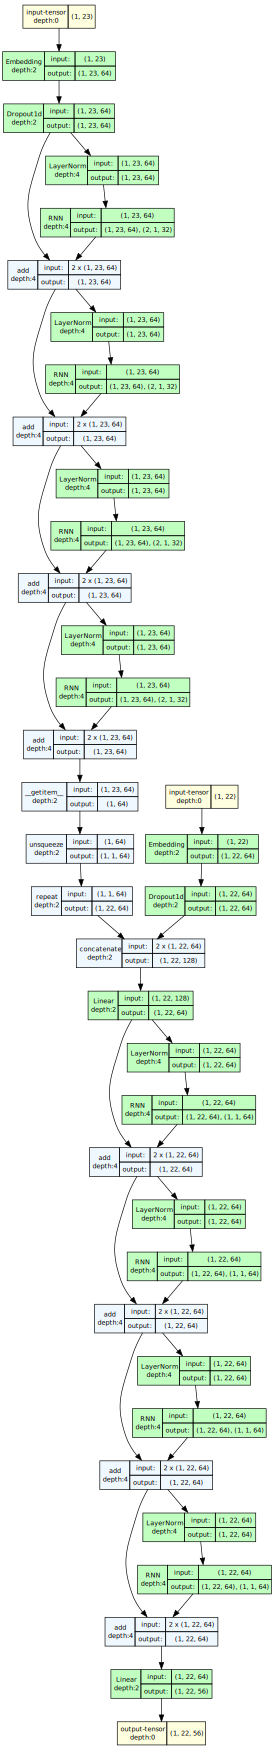

In [39]:
model_graph = draw_graph(enc_dec_net,
                         input_data=[torch.Tensor(enc_x_train[0:1]).long(),
                                     torch.Tensor(dec_x_train[0:1]).long()], 
                         device=device,
                         hide_inner_tensors=True,
                         hide_module_functions=True, 
                         expand_nested=False, 
                         depth=4, 
                         dtypes=[torch.long])

model_graph.visual_graph

In [40]:
batch_size = 20
xy_train = torch.utils.data.DataLoader(list(zip(torch.Tensor(enc_x_train).long(),
                                                torch.Tensor(dec_x_train).long(),
                                                torch.Tensor(dec_y_train).long())), 
                                       shuffle=True, 
                                       batch_size=batch_size, 
                                       num_workers=8)

xy_val = torch.utils.data.DataLoader(list(zip(torch.Tensor(enc_x_val).long(), 
                                              torch.Tensor(dec_x_val).long(),
                                              torch.Tensor(dec_y_val).long())), 
                                     shuffle=False, 
                                     batch_size=batch_size, 
                                     num_workers=8)

/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [41]:
logger = pl.loggers.CSVLogger("lightning_logs", 
                              name="Open_Lab_4",
                              version="demo-0")

In [42]:
trainer = pl.Trainer(logger=logger, max_epochs=300,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=False, 
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [43]:
trainer.validate(enc_dec_net, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │   0.005681818351149559    │
│         val_loss          │     4.304074287414551     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.005681818351149559, 'val_loss': 4.304074287414551}]

In [44]:
trainer.test(enc_dec_net, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │   0.005681818351149559    │
│         test_loss         │     4.483646392822266     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.005681818351149559, 'test_loss': 4.483646392822266}]

In [ ]:
trainer.fit(enc_dec_net, xy_train, xy_val) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | mc_acc   | MulticlassAccuracy | 0     
1 | cce_loss | CrossEntropyLoss   | 0     
2 | enc_net  | EncoderNetwork     | 28.4 K
3 | dec_net  | DecoderNetwork     | 49.3 K
------------------------------------------------
77.7 K    Trainable params
0         Non-trainable params
77.7 K    Total params
0.311     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [46]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")
results

,val_acc,val_loss,epoch,step,test_acc,test_loss,train_acc,train_loss
0,0.005682,4.304074,0,0,NaN,NaN,NaN,NaN
1,NaN,NaN,0,0,0.005682,4.483646,NaN,NaN
2,0.232955,3.381238,0,3,NaN,NaN,NaN,NaN
3,NaN,NaN,0,3,NaN,NaN,0.095816,3.815603
4,0.244318,3.016538,1,7,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
597,NaN,NaN,297,1191,NaN,NaN,0.752423,0.638893
598,0.500000,2.722973,298,1195,NaN,NaN,NaN,NaN
599,NaN,NaN,298,1195,NaN,NaN,0.754551,0.596562
600,0.494318,2.749142,299,1199,NaN,NaN,NaN,NaN


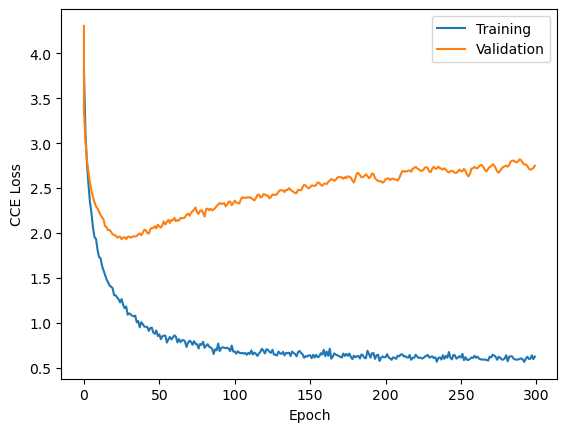

In [48]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))], 
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))], 
         label="Validation")

plt.legend() 
plt.ylabel("CCE Loss") 
plt.xlabel("Epoch") 
plt.show()

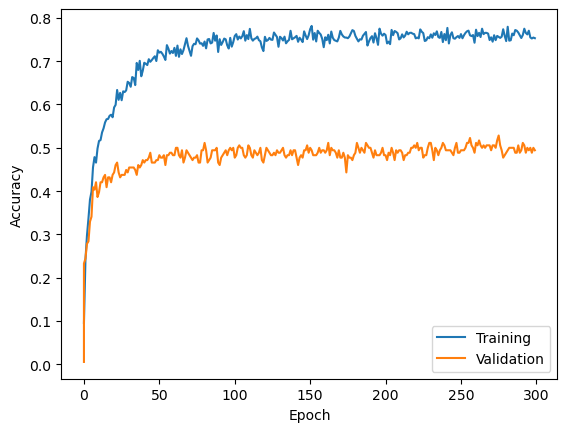

In [49]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_acc"]))], 
         results["train_acc"][np.logical_not(np.isnan(results["train_acc"]))], 
         label="Training")
plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_acc"]))], 
         results["val_acc"][np.logical_not(np.isnan(results["val_acc"]))], 
         label="Validation")

plt.legend() 
plt.ylabel("Accuracy")
plt.xlabel("Epoch") 
plt.show()

In [50]:
print("")
print("Validation accuracy:", *["%.8f"%(x) for x in results['val_acc'][np.logical_not(np.isnan(results["val_acc"]))]])
print("")
print("")


Validation accuracy: 0.00568182 0.23295455 0.24431820 0.27840909 0.28409091 0.32954547 0.34090909 0.40909091 0.40340909 0.42045456 0.38636363 0.39772728 0.42045456 0.42045456 0.43181819 0.43750000 0.40909091 0.43181819 0.43181819 0.42045456 0.43750000 0.44318181 0.46022731 0.46590909 0.44318181 0.43181819 0.43750000 0.43750000 0.43750000 0.44886360 0.44318181 0.45454544 0.45454544 0.45454544 0.45454544 0.44886360 0.43750000 0.46022731 0.45454544 0.46022731 0.47159091 0.46590909 0.47159091 0.47159091 0.47727269 0.48863640 0.46590909 0.46590909 0.46590909 0.47159091 0.47159091 0.48295456 0.47727269 0.47727269 0.48295456 0.46022731 0.48295456 0.48295456 0.48863640 0.48863640 0.48295456 0.48295456 0.50000000 0.50000000 0.48295456 0.47727269 0.49431819 0.46590909 0.47727269 0.49431819 0.48863640 0.48295456 0.47727269 0.47159091 0.47727269 0.47727269 0.48295456 0.46590909 0.46590909 0.49431819 0.49431819 0.51136363 0.49431819 0.46590909 0.47159091 0.47727269 0.49431819 0.49431819 0.49431819